In [3]:
# # Spotify Popularity - Neural Network (TensorFlow + KerasTuner)
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # TensorFlow uyarılarını gizle
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#!pip install keras_tuner
import keras_tuner as kt
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [ ]:
# # %%
# df = pd.read_csv("scaled_data.csv")
# df["popularity"] = (df["popularity"] + 1) ** 0.5
# # y_smooth = (y + 1) ** 0.5
# print(df.columns)

# print(df.head())
# print(df.shape)

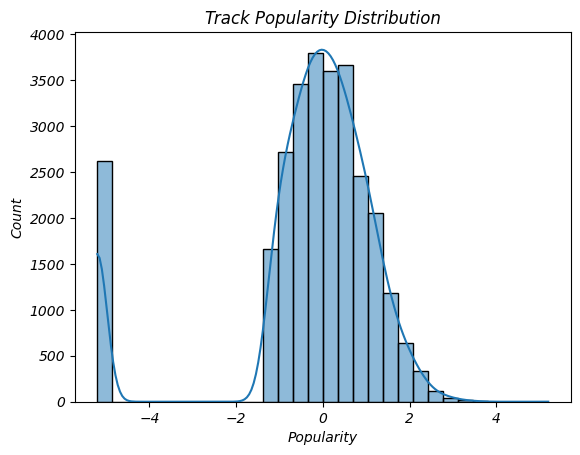

In [4]:
df = pd.read_csv("final_data.csv")
# df = df[:10000]
y = df["popularity"].values.reshape(-1, 1)

qt = QuantileTransformer(output_distribution="normal", random_state=42)
df["popularity"] = qt.fit_transform(y).ravel()
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Track Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

In [5]:
# %%
target_col = "popularity"  # burada kendi target adını kullan
X = df.drop(columns=[target_col])
y = df[target_col]
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (28356, 42)
Target shape: (28356,)


In [6]:
# %%
# önce train+temp, sonra temp'i val+test olarak ayırıyoruz
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)


Train: (19849, 42) (19849,)
Val: (4253, 42) (4253,)
Test: (4254, 42) (4254,)


In [ ]:
# %%
def build_model(hp: kt.HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input(shape=(42,)))

    # kaç tane hidden layer
    n_layers = hp.Int("n_layers", min_value=2, max_value=5)

    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.BatchNormalization())
        dropout_rate = hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.4, step=0.1)
        model.add(layers.Dropout(dropout_rate))

    # output layer (regression → 1 nöron)
    model.add(layers.Dense(1, activation="linear"))

    # learning rate
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.Huber(),
        metrics=["mae"]
    )

    return model

In [ ]:
# %%
# Eski tuner loglarını temizle (yeni aramaya başlamak için)
import shutil
import os
if os.path.exists("nn_tuner_logs"):
    shutil.rmtree("nn_tuner_logs")
    print("🗑️ Eski tuner logları silindi, yeni arama başlıyor...")

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=10,           # 15 farklı kombinasyon deneyecek
    directory="nn_tuner_logs",
    project_name="spotify_popularity_nn",
    overwrite=True           # Eski sonuçların üzerine yaz
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# %%
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,           # istersen bunu da hp'ye açabiliriz
    callbacks=[early_stop],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)


Trial 10 Complete [00h 00m 47s]
val_loss: 0.43535494804382324

Best val_loss So Far: 0.38091397285461426
Total elapsed time: 00h 12m 09s
Best hyperparameters: {'n_layers': 2, 'units_0': 64, 'dropout_0': 0.1, 'units_1': 64, 'dropout_1': 0.2, 'learning_rate': 0.00010278546049636793, 'units_2': 160, 'dropout_2': 0.4, 'units_3': 256, 'dropout_3': 0.1, 'units_4': 160, 'dropout_4': 0.2}


In [ ]:
# %%
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9094 - mae: 1.3055 - val_loss: 0.5953 - val_mae: 0.9368
Epoch 2/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7450 - mae: 1.1210 - val_loss: 0.5452 - val_mae: 0.8686
Epoch 3/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6836 - mae: 1.0530 - val_loss: 0.5162 - val_mae: 0.8241
Epoch 4/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6426 - mae: 1.0021 - val_loss: 0.4994 - val_mae: 0.7988
Epoch 5/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6183 - mae: 0.9722 - val_loss: 0.4873 - val_mae: 0.7808
Epoch 6/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5878 - mae: 0.9352 - val_loss: 0.4783 - val_mae: 0.7721
Epoch 7/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5742 - mae: 0.9173 - val_loss: 0.4733 - val_mae: 0.7642
Epoch 8/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5551 - mae: 0.8950 - val_loss: 0.4692 - val_mae: 0.7612
Epoch 9/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

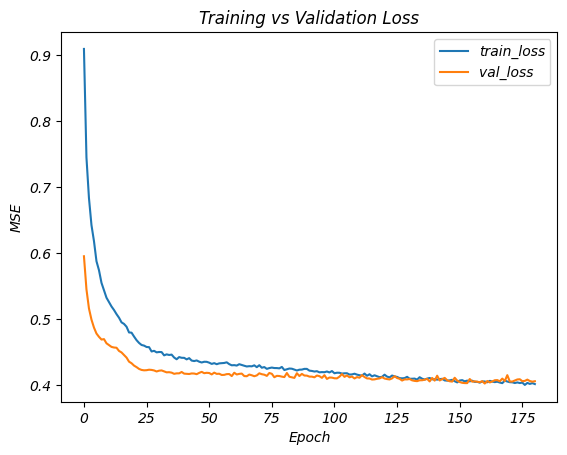

In [ ]:
# %%
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
# %%
# Test setinde tahmin yap (transform edilmiş değerler)
y_pred_test_trans = best_model.predict(X_test).ravel()

# Orijinal ölçeğe çevir
y_pred_test_original = qt.inverse_transform(y_pred_test_trans.reshape(-1, 1)).ravel()
y_test_original = qt.inverse_transform(y_test.values.reshape(-1, 1)).ravel()

print(f"Tahmin istatistikleri:")
print(f"Min: {y_pred_test_original.min():.2f}, Max: {y_pred_test_original.max():.2f}")
print(f"100'ü aşan tahmin sayısı: {(y_pred_test_original > 100).sum()}")
print(f"0'ın altında tahmin sayısı: {(y_pred_test_original < 0).sum()}")

# Orijinal ölçekteki metrikler (clipping olmadan)
mae_original  = mean_absolute_error(y_test_original, y_pred_test_original)
mse_original  = mean_squared_error(y_test_original, y_pred_test_original)
rmse_original = np.sqrt(mse_original)
r2_original   = r2_score(y_test_original, y_pred_test_original)

print("\n=== Orijinal Ölçekte Test Metrikleri ===")
print(f"MAE  : {mae_original:.2f}")
print(f"RMSE : {rmse_original:.2f}")
print(f"MSE  : {mse_original:.2f}")
print(f"R²   : {r2_original:.4f}")

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
Tahmin istatistikleri:
Min: 0.00, Max: 100.00
100'ü aşan tahmin sayısı: 0
0'ın altında tahmin sayısı: 0

=== Orijinal Ölçekte Test Metrikleri ===
MAE  : 9.93
RMSE : 15.42
MSE  : 237.62
R²   : 0.5819


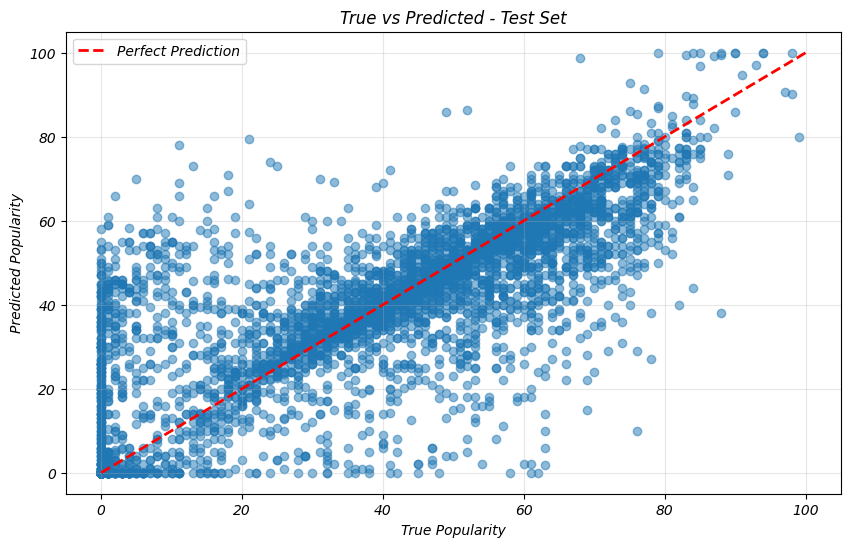

In [ ]:
# %%
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_test_original, alpha=0.5)
plt.xlabel("True Popularity")
plt.ylabel("Predicted Popularity")
plt.title("True vs Predicted - Test Set")
# y=x referans çizgisi
min_val = min(y_test_original.min(), y_pred_test_original.min())
max_val = max(y_test_original.max(), y_pred_test_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# %%
#best_model.save("best_nn_spotify.keras")


In [ ]:
# %%
#best_model.save("best_nn_spotify.h5")
